# Yelp Data Text Analysis and Modeling

This notebook demonstrates a complete pipeline for exploring, preprocessing, and modeling a subset of the Yelp dataset. The main objective is to predict whether a Yelp review is “more useful” or “less useful” based on both text and numeric features. We employ multiple classification techniques, including:

- Traditional machine learning models (Logistic Regression, Random Forest, etc.)
- Imbalanced-learning approaches (Cost-sensitive learning)
- Ensemble methods (AdaBoost, Stacking)
- Deep Learning architectures (BERT, LSTM, Multi-Input Models)

This notebook contains the following steps:

1. **Data Loading & Preprocessing**
2. **Exploratory Data Analysis (EDA)**
3. **Feature Engineering** (Numeric, Text, & Dimensionality Reduction)
4. **Model Training & Evaluation** (with cross-validation, metrics, and interpretability)
5. **Advanced Methods** (Imbalanced classification, ensembles, and deep learning approaches)

### Setup and Global Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [2]:
import os
import sys
import numpy as np
import pandas as pd

# os.chdir('/content/gdrive/MyDrive/utils')

utils_path = os.path.join(os.getcwd(), "utils")
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility modules (preprocessing, plotting, modeling, etc.)
from preprocessing import (
    load_and_clean_data, transform_numeric_features, impute_binary_columns,
    TextTransformer, transform_text_features
)
from plotting import (
    plot_numeric_histograms, plot_categorical_bars, plot_target_distribution
)
from modeling import create_preprocessor
from ensemble import adacost_train, adacost_predict
from deep_learning import finetune_bert, build_lstm_model, build_multi_input_model
from evaluation import comprehensive_evaluation

# Additional libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import ADASYN

# Ensure tokenizer parallelism is disabled (for transformers)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## 1. Data Loading and Initial Cleaning

We begin by loading multiple raw Yelp JSON files (`review`, `user`, and `business`) into a **SQLite** database. This approach lets us select only relevant columns and neatly join the three tables, which contain review text, user attributes (e.g., fans, average_stars), and business details (e.g., parking/ambience attributes).

Next, we **expand** dictionary-like fields (e.g., `BusinessParking`, `Ambience`) into separate boolean columns and merge **ZIP code income data** from a Kaggle dataset. This step creates a richer feature space (e.g., a numeric `parking_count` and `region_income`). We also **filter** out average or low-usefulness reviews, retaining only “less useful” (< 40th percentile) and “more useful” (> 60th percentile) ones for clearer labeling.

Finally, the pipeline **consolidates** all information into a single CSV (`yelp_reduced.csv`). The `load_and_clean_data` function in `preprocessing.py` then removes columns irrelevant for modeling (IDs, etc.) and converts binary fields (like price range) to numeric codes, leaving a streamlined dataset ready for analysis.

In [3]:
file_path = os.path.join("../yelp_dataset", "yelp_reduced.csv")
# file_path = "/content/gdrive/MyDrive/yelp_dataset/yelp_reduced.csv"
df = load_and_clean_data(file_path)

In [4]:
cols_to_keep = [
    'text', 'stars', 'useful_category', 'user_review_count',
    'average_stars', 'fans', 'business_stars', 'business_review_count',
    'user_total_votes', 'user_total_compliments', 'parking_count',
    'region_income', 'price_binary', 'attire_binary'
]

df = df[cols_to_keep].rename(columns={"user_total_votes": "user_previous_useful"})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117807 entries, 0 to 1117806
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   text                    1117807 non-null  object 
 1   stars                   1117807 non-null  float64
 2   useful_category         1117807 non-null  object 
 3   user_review_count       1117807 non-null  float64
 4   average_stars           1117807 non-null  float64
 5   fans                    1117807 non-null  float64
 6   business_stars          1117807 non-null  float64
 7   business_review_count   1117807 non-null  int64  
 8   user_previous_useful    1117807 non-null  float64
 9   user_total_compliments  1117807 non-null  float64
 10  parking_count           1117807 non-null  int64  
 11  region_income           1117807 non-null  float64
 12  price_binary            859135 non-null   float64
 13  attire_binary           578265 non-null   float64
dtypes:

From the output:
- The dataset includes numeric and object (text, useful_category) columns.
- Columns like `price_binary` and `attire_binary` have missing values.

## 2. Splitting Data into Features and Target

- We are predicting whether each Yelp review is “less useful” or “more useful,” stored in the `useful_category` column.
- We use a standard 80/20 train-test split with `stratify=y` to preserve class distribution in both sets.

In [6]:
X = df.drop(columns=['useful_category'])
y = df['useful_category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 3. Imputation for Binary Columns

We impute missing values in the `price_binary` and `attire_binary` columns using a KNN classifier. For each binary column, the KNN model is trained on rows where the column is known, using the other numeric features (excluding the text column) as predictors. Note that the KNN model is fit and validated on the train sets only. We then fill in the missing rows for both training and test sets with the KNN’s predictions. This approach leverages local similarity among rows to provide more data-driven imputation than a simple mean or mode fill, helping preserve valuable samples for downstream modeling.

In [7]:
binary_cols = ['price_binary', 'attire_binary']
X_train, X_test = impute_binary_columns(X_train, X_test, binary_cols)


Imputing missing values for: price_binary
CV scores for price_binary: [0.91320886 0.91207424 0.91334643 0.91252455 0.91298276]
Mean CV accuracy for price_binary: 0.9128
Remaining missing values in train for price_binary: 0
Remaining missing values in test for price_binary: 0

Imputing missing values for: attire_binary
CV scores for attire_binary: [0.96614949 0.96622476 0.9658574  0.96588981 0.96617073]
Mean CV accuracy for attire_binary: 0.9661
Remaining missing values in train for attire_binary: 0
Remaining missing values in test for attire_binary: 0


Outputs above shows cross-validation accuracies (90%+) for each binary column predictor and confirms no more missing values.

## 4. Exploratory Data Analysis (EDA)

- We look at **numerical features** (e.g., `business_review_count`, `average_stars`, etc.) to see if they are skewed or if there are outliers. If skewness is present, in the preprocessing we transform the skewed features.
- We look at **categorical features** (e.g., `stars`, `parking_count`, `price_binary`) to understand their frequency distribution.
- Finally, we look at our **target variable** distribution to check for imbalance—this can inform whether we need strategies like cost-sensitive learning or oversampling, or use models insensitive to class imbalance.

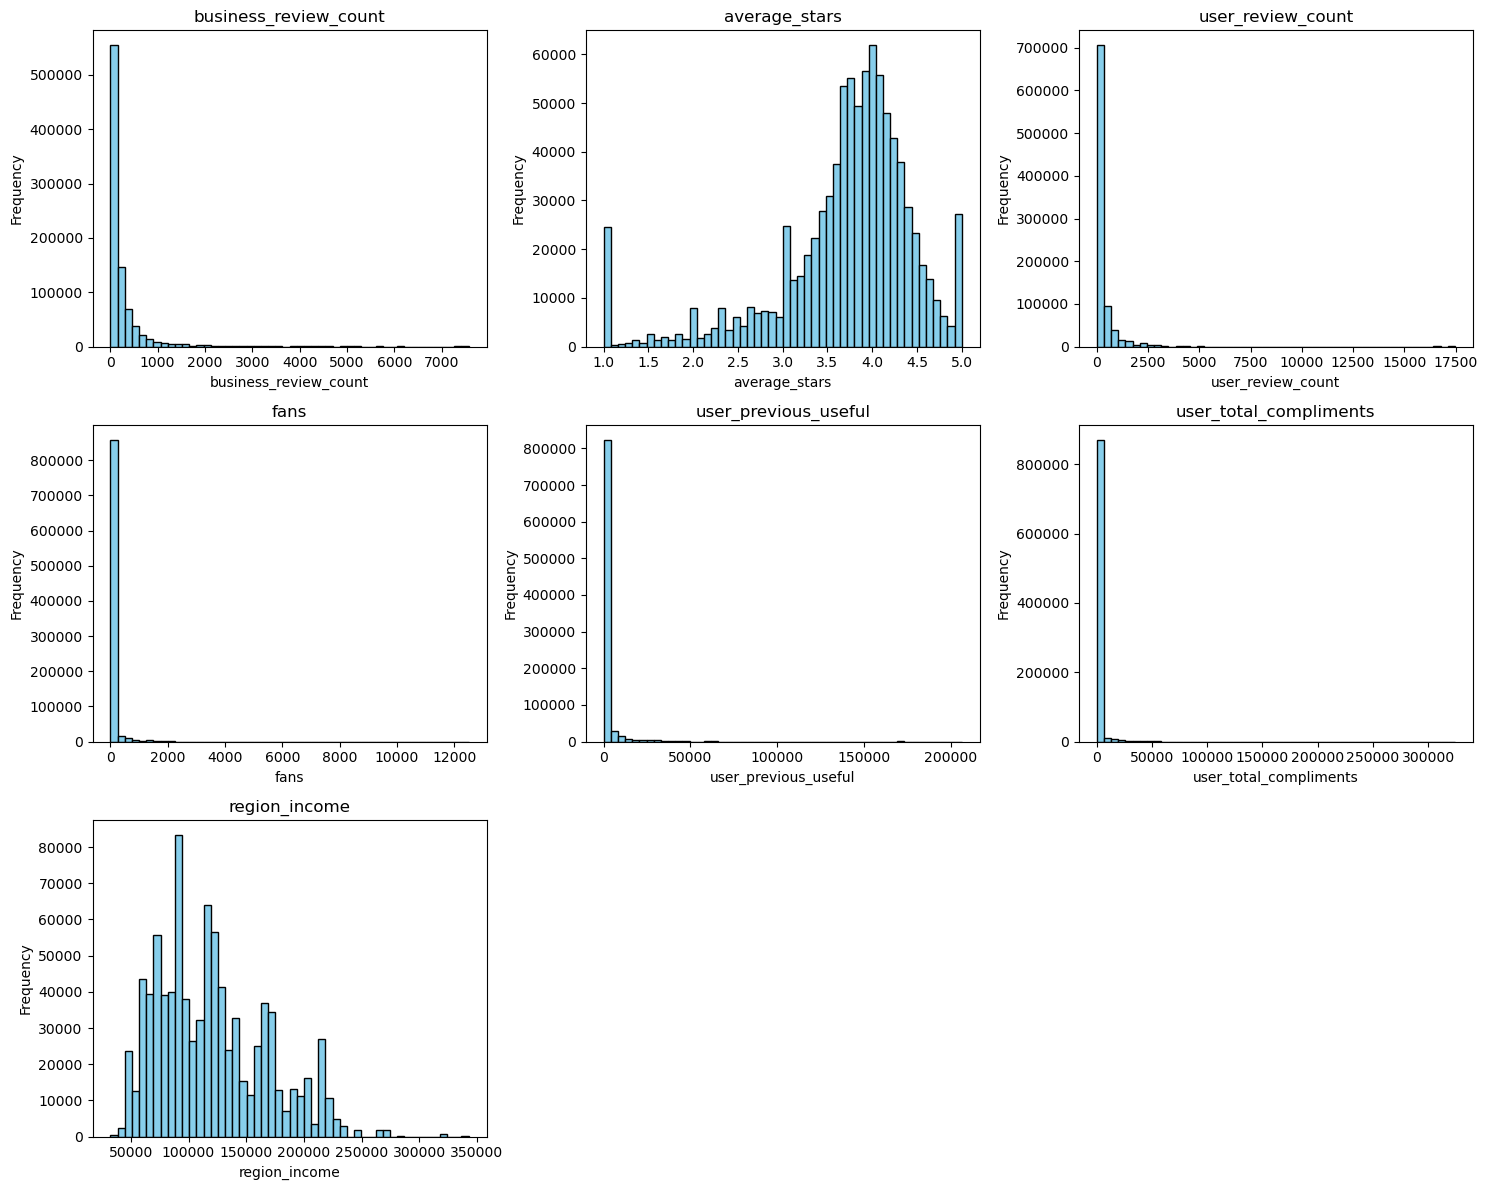

In [8]:
# Numeric Features Histogram
num_cols = ['business_review_count', 'average_stars', 'user_review_count',
            'fans', 'user_previous_useful', 'user_total_compliments', 'region_income']
plot_numeric_histograms(X_train, num_cols)

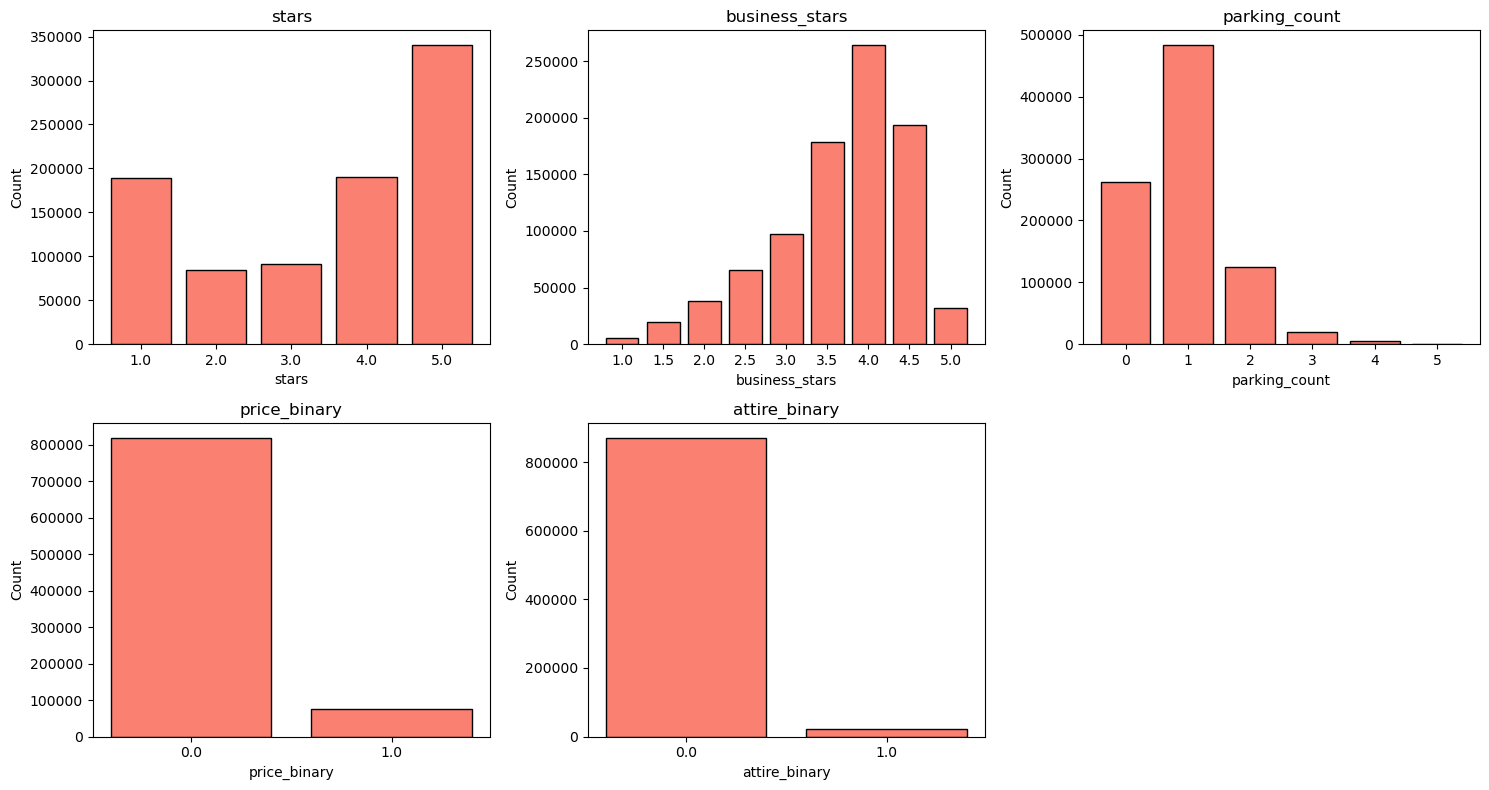

In [9]:
# Categorical Features Bar Charts
cat_cols = ['stars', 'business_stars', 'parking_count', 'price_binary', 'attire_binary']
plot_categorical_bars(X_train, cat_cols)

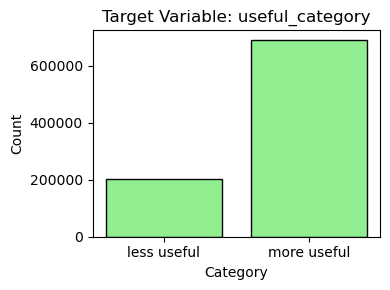

In [10]:
# Target Variable Distribution
plot_target_distribution(y_train, "Target Variable: useful_category")

## 5. Numeric Feature Transformation

- Many features exhibit **skewness** (e.g., `user_total_votes` can be heavily skewed, meaning most users have few votes, but a small percentage have very high counts).
- We apply **log-transform** to highly skewed features to mitigate extreme values and approximate a more normal distribution.
- We also scale the numeric features.
- This step typically helps models like Logistic Regression converge more reliably.

Shifting user_previous_useful by 51.0 to avoid negative values.


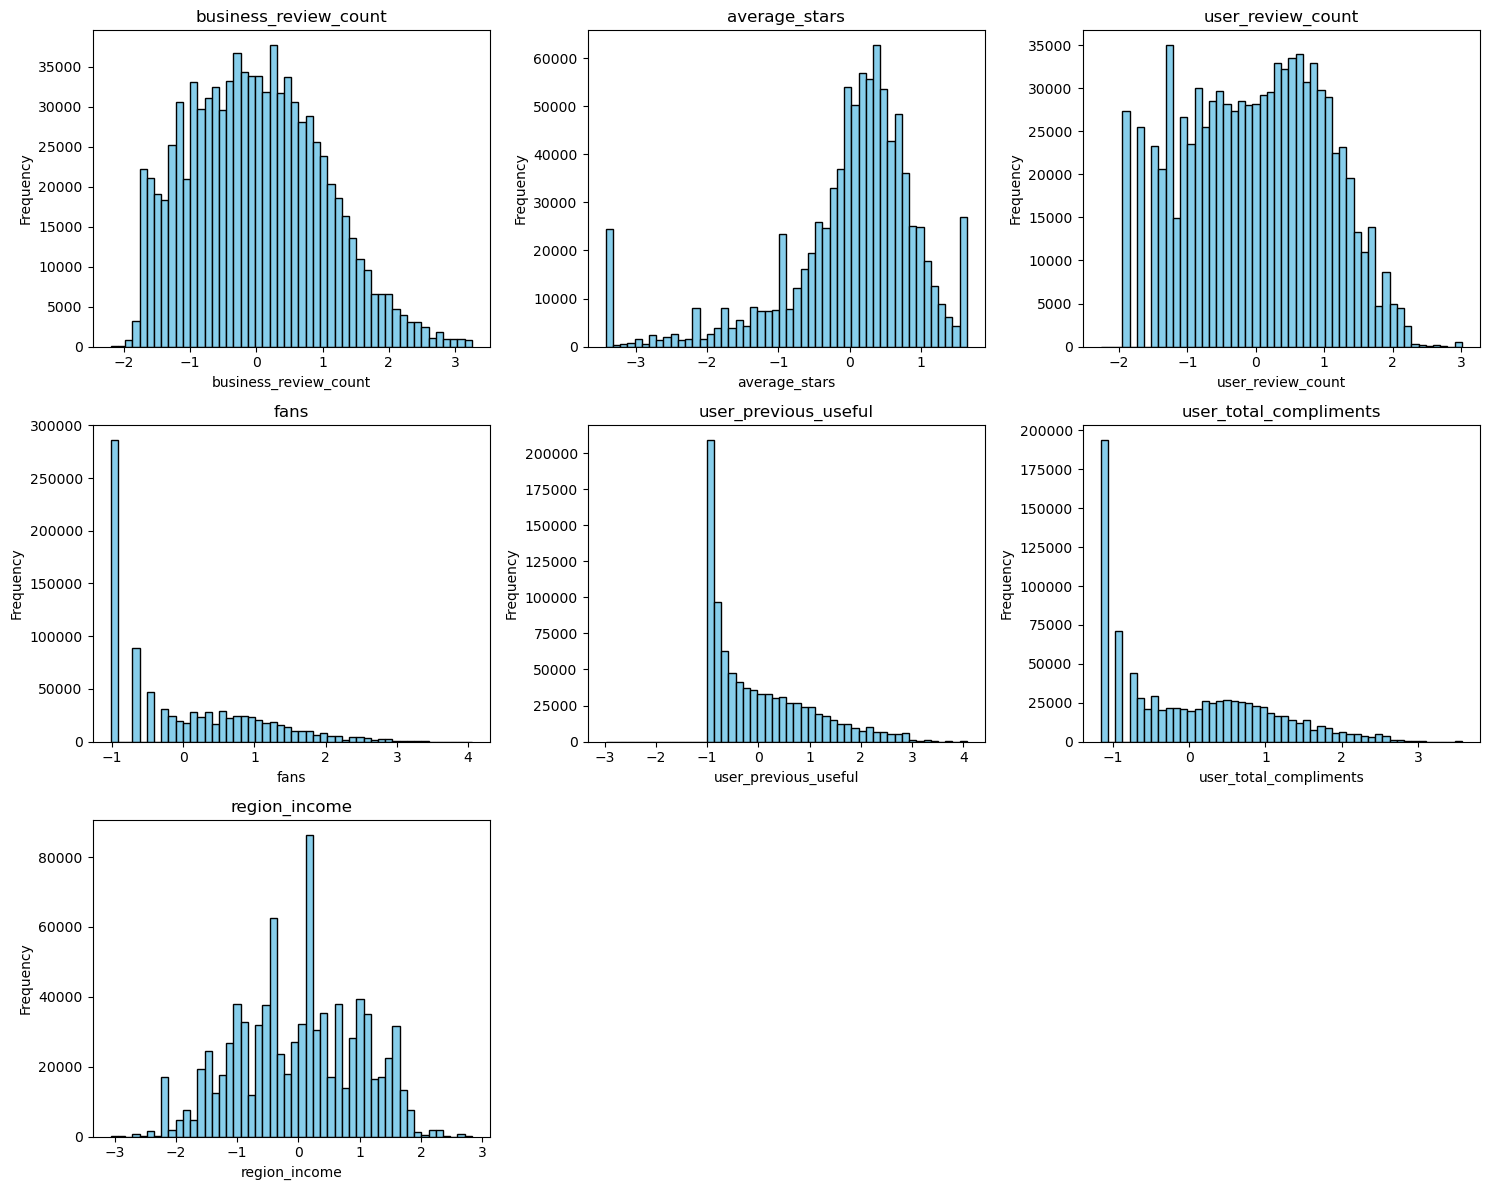

In [11]:
skewed_features = ['business_review_count', 'user_review_count', 'fans',
                   'user_previous_useful', 'user_total_compliments', 'region_income']
numeric_features = ['average_stars', 'business_stars', 'parking_count']
stars_feature = ['stars']

X_train, X_test = transform_numeric_features(X_train, X_test, skewed_features, numeric_features, stars_feature)
plot_numeric_histograms(X_train, num_cols)

## 6. Text Feature Engineering

In TextTransformer, we:
- use sentence-level embeddings (SBERT).
- apply PCA (to reduce dimensionality).
- apply LDA (to capture thematic information).
- use TF-IDF vectorization to capture n-grams.

Balancing performance and dimensionality is key; we may not want thousands of raw n-gram features, so PCA helps keep a manageable size.

In [12]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV

# pipeline = Pipeline([
#     ('text_transformer', TextTransformer()),
#     ('classifier', LogisticRegression(max_iter=1000))
# ])

# # Define a grid to test different configurations:
# param_grid = {
#     'text_transformer__use_lda': [True, False],
#     'text_transformer__lda_topics': [5, 10],
#     'text_transformer__vectorizer_type': ['count', 'tfidf'],
#     # Experiment with unigrams vs. unigrams+bigrams
#     'text_transformer__ngram_range': [(1, 1), (1, 2)]
# }

# grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=0)
# grid.fit(X_train, y_train)

# print("Best parameters:", grid.best_params_)
# print("Best cross-validation accuracy:", grid.best_score_)

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob
from bertopic import BERTopic

class GPUTextTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,
                 sbert_model_name: str = 'all-MiniLM-L6-v2',
                 use_topic_model: bool = True,  # Use BERTopic for topic extraction
                 topic_model_num: int = 100,        # Desired number of topics
                 count_max_features: int = 1000,
                 tfidf_max_features: int = 500,
                 vectorizer_type: str = 'tfidf',  # Options: 'count', 'tfidf', 'both'
                 ngram_range: tuple = (1, 2)):
        self.sbert_model_name = sbert_model_name
        self.use_topic_model = use_topic_model
        self.topic_model_num = topic_model_num
        self.count_max_features = count_max_features
        self.tfidf_max_features = tfidf_max_features
        self.vectorizer_type = vectorizer_type
        self.ngram_range = ngram_range

    def fit(self, X: pd.DataFrame, y=None):
        # Set up vectorizers based on vectorizer_type
        if self.vectorizer_type in ['count', 'both']:
            self.count_vectorizer_ = CountVectorizer(max_features=self.count_max_features,
                                                     stop_words='english',
                                                     ngram_range=self.ngram_range)
            self.count_vectorizer_.fit(X['text'])
        if self.vectorizer_type in ['tfidf', 'both']:
            self.tfidf_vectorizer_ = TfidfVectorizer(max_features=self.tfidf_max_features,
                                                     stop_words='english',
                                                     ngram_range=self.ngram_range)
            self.tfidf_vectorizer_.fit(X['text'])

        # Fit BERTopic for topic modeling if enabled
        if self.use_topic_model:
            self.topic_model_ = BERTopic(
                embedding_model=self.sbert_model_name,  # BERTopic accepts a model name directly
                nr_topics=self.topic_model_num,
                calculate_probabilities=True,
                verbose=True
            )
            texts = X['text'].tolist()
            topics, probs = self.topic_model_.fit_transform(texts)
        return self

    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_ = X.copy()
        # Extract sentiment feature using TextBlob
        X_['sentiment'] = X_['text'].apply(lambda txt: TextBlob(str(txt)).sentiment.polarity)

        # Use BERTopic to extract topic probabilities if enabled
        if self.use_topic_model:
            texts = X_['text'].tolist()
            topics, probs = self.topic_model_.transform(texts)
            if probs is not None:
                topic_cols = [f"topic_prob_{i}" for i in range(probs.shape[1])]
                df_topics = pd.DataFrame(probs, columns=topic_cols, index=X_.index)
                X_ = pd.concat([X_, df_topics], axis=1)
            else:
                X_['topic'] = topics

        # Add Count/Tfidf vectorizer features
        vectorizer_dfs = []
        if self.vectorizer_type in ['count', 'both']:
            count_features = self.count_vectorizer_.transform(X_['text'])
            count_cols = [f"count_{w}" for w in self.count_vectorizer_.get_feature_names_out()]
            df_count = pd.DataFrame(count_features.toarray(), columns=count_cols, index=X_.index)
            vectorizer_dfs.append(df_count)
        if self.vectorizer_type in ['tfidf', 'both']:
            tfidf_features = self.tfidf_vectorizer_.transform(X_['text'])
            tfidf_cols = [f"tfidf_{w}" for w in self.tfidf_vectorizer_.get_feature_names_out()]
            df_tfidf = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_cols, index=X_.index)
            vectorizer_dfs.append(df_tfidf)
        if vectorizer_dfs:
            df_vectorizers = pd.concat(vectorizer_dfs, axis=1)
            X_ = pd.concat([X_, df_vectorizers], axis=1)

        # Remove the original text column to avoid duplication
        X_.drop(columns=['text'], inplace=True)
        return X_

In [ ]:
# text_transformer = TextTransformer(
#     sbert_model_name='all-MiniLM-L6-v2',
#     pca_components=200,
#     lda_topics=5,
#     vectorizer_type='tfidf',
#     tfidf_max_features=500,
#     ngram_range=(1, 2),
# )
text_transformer = GPUTextTransformer()
X_train_text, X_test_text = transform_text_features(X_train, X_test, y_train, text_transformer)
print("X_train_transformed shape:", X_train_text.shape)
print("X_test_transformed shape:", X_test_text.shape)

2025-03-03 21:55:44,072 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2795 [00:00<?, ?it/s]

2025-03-03 22:00:07,233 - BERTopic - Embedding - Completed ✓
2025-03-03 22:00:07,234 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-03 22:00:30,583 - BERTopic - Dimensionality - Completed ✓
2025-03-03 22:00:30,584 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-03 22:12:43,286 - BERTopic - Cluster - Completed ✓
2025-03-03 22:12:43,289 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-03 22:12:46,861 - BERTopic - Representation - Completed ✓
2025-03-03 22:12:46,865 - BERTopic - Topic reduction - Reducing number of topics
2025-03-03 22:12:50,252 - BERTopic - Topic reduction - Reduced number of topics from 439 to 100


Batches:   0%|          | 0/27946 [00:00<?, ?it/s]

To-do: after combining numeric features, textual embeddings, and dimensionality reduction, there are xx columns.

## 7. Preprocessing for Modeling

We create a preprocessor that likely does scaling and one-hot encoding. Then we transform the entire training and test sets using that pipeline.

In [ ]:
original_cols = list(X_train_text.columns)
preprocessor = create_preprocessor(X_train_text)
X_train_ready = preprocessor.fit_transform(X_train_text)
X_test_ready = preprocessor.transform(X_test_text)
print("X_train_ready shape:", X_train_ready.shape)
print("X_test_ready shape:", X_test_ready.shape)

X_train_ready shape: (89424, 612)
X_test_ready shape: (22357, 612)


## 8. Classic Machine Learning Models

- We start with Logistic Regression without using text features at all as a baseline.
- Then we measure performance with the custom comprehensive_evaluation function, which:
    * Prints classification metrics (precision, recall, F1, accuracy).
    * Performs cross-validation with the chosen scoring metric.
    * Optionally provides interpretability with LIME or SHAP, showing feature importances or local explanations.

We also use other algorithms like Random Forest to see if the F1 score or recall improves.

### 8.1 Baseline Logistic Regression (Numeric Only Example)

In [ ]:
log_reg = LogisticRegression(C=0.05, penalty='l2', solver='liblinear')
X_train_num = X_train.drop(columns='text', axis=1)
X_test_num = X_test.drop(columns='text', axis=1)
log_reg.fit(X_train_num, y_train)

LogisticRegression(C=0.05, solver='liblinear')


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.5734    0.2551    0.3531     20585
 more useful     0.8090    0.9432    0.8710     68839

    accuracy                         0.7848     89424
   macro avg     0.6912    0.5992    0.6120     89424
weighted avg     0.7547    0.7848    0.7518     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.5797    0.2600    0.3590      5147
 more useful     0.8100    0.9436    0.8717     17210

    accuracy                         0.7862     22357
   macro avg     0.6949    0.6018    0.6153     22357
weighted avg     0.7570    0.7862    0.7537     22357



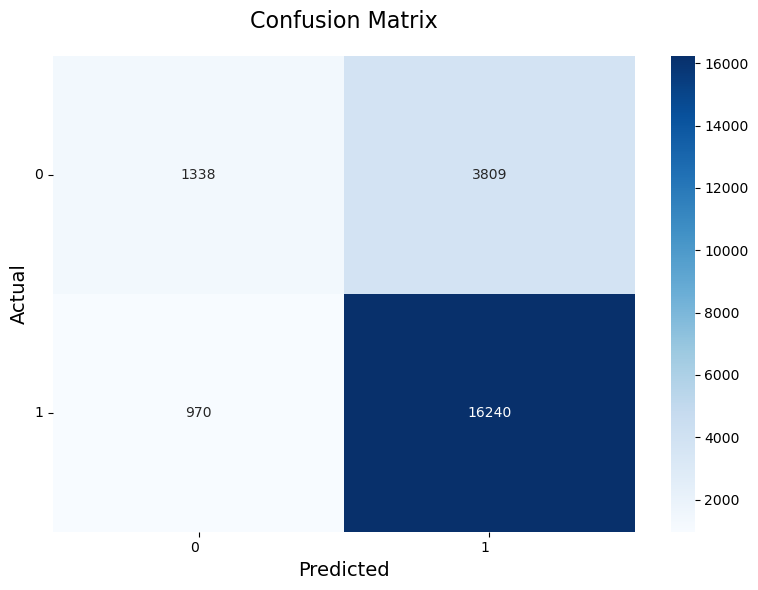

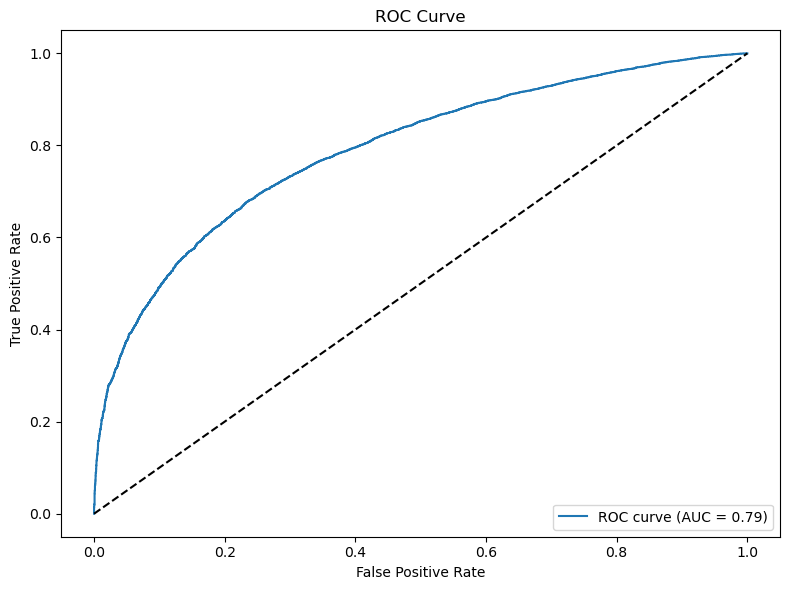

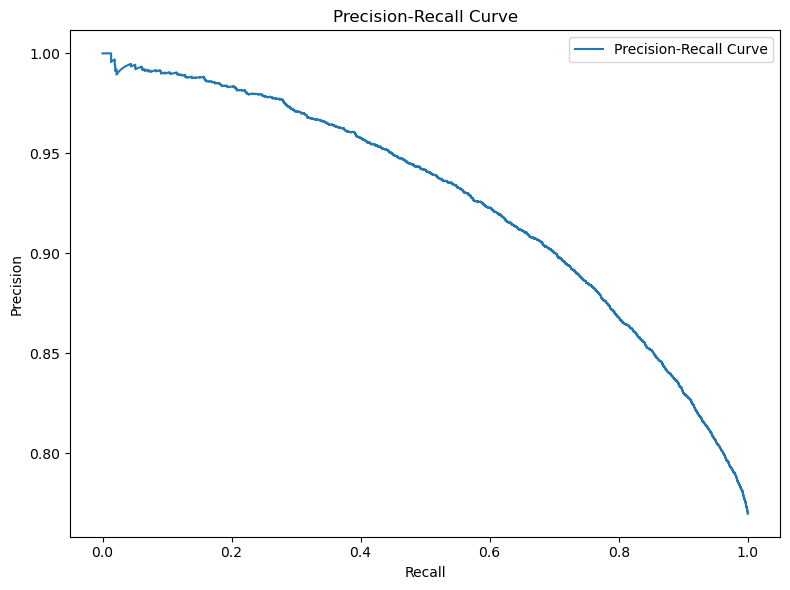

No feature importance attribute found for this model.
LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                                Feature  Contribution
                   0.34 < stars <= 0.98   

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_num, y_train, X_test_num, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

### 8.2 Logistic Regression with Text + Numeric Features

(TO-do: check)
Usually, including text features substantially improves model performance, because the text provides direct cues about the sentiment and details of the user’s experience.
The LIME explanations show which words or embedding components push the classifier towards predicting “more useful” or “less useful.”

In [ ]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
log_reg.fit(X_train_ready, y_train)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.6120    0.3526    0.4474     20585
 more useful     0.8282    0.9331    0.8775     68839

    accuracy                         0.7995     89424
   macro avg     0.7201    0.6429    0.6625     89424
weighted avg     0.7784    0.7995    0.7785     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.6060    0.3604    0.4520      5147
 more useful     0.8294    0.9299    0.8768     17210

    accuracy                         0.7988     22357
   macro avg     0.7177    0.6452    0.6644     22357
weighted avg     0.7780    0.7988    0.7790     22357



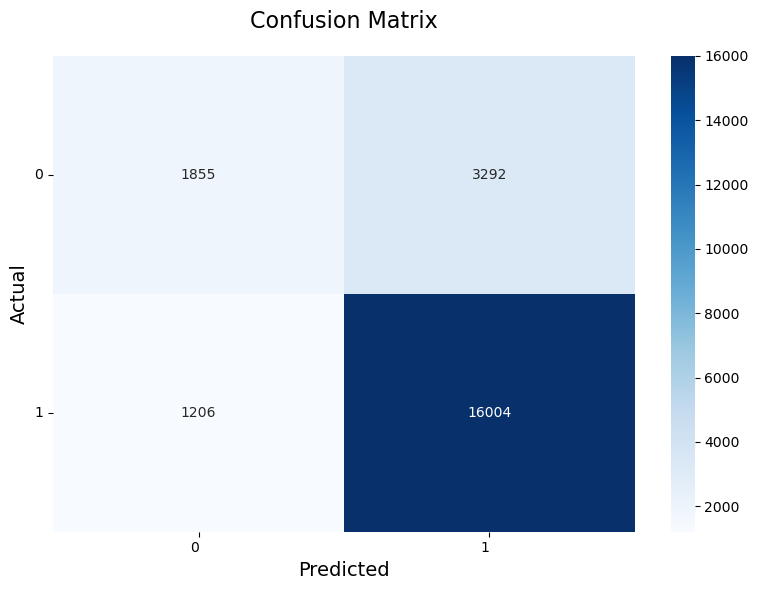

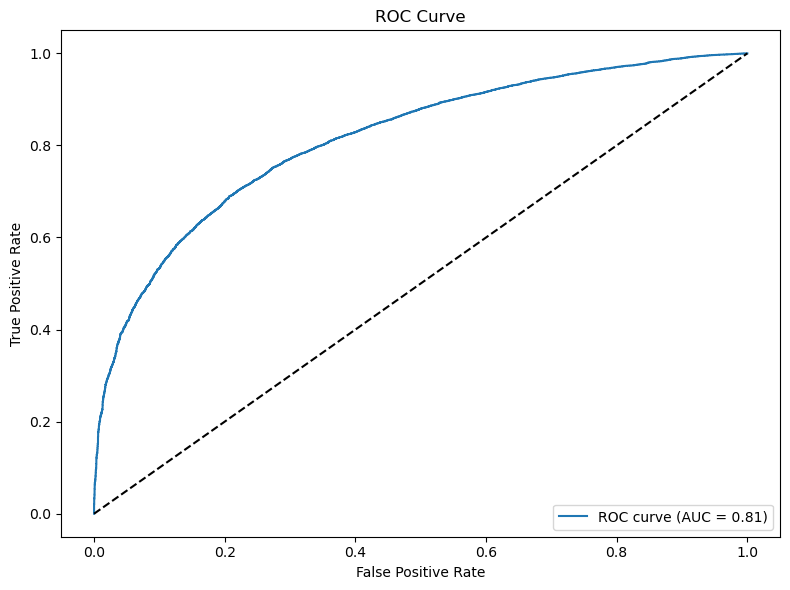

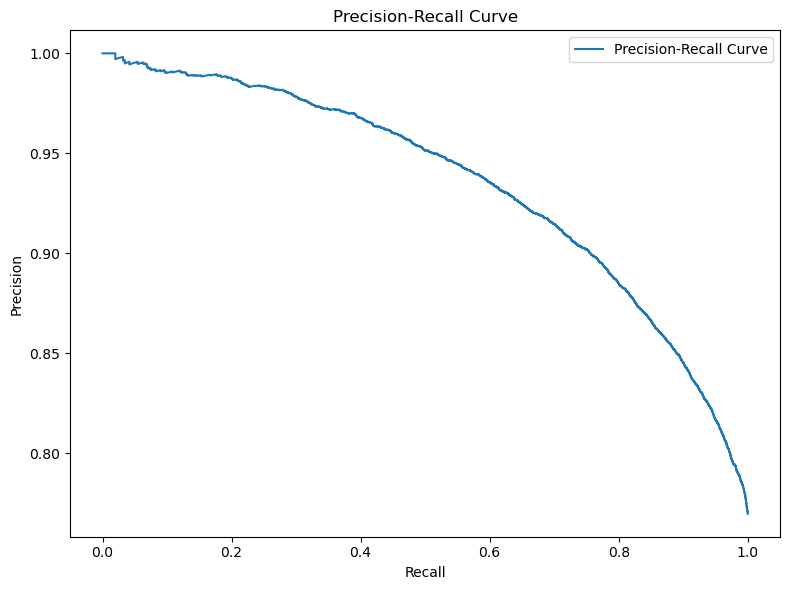

No feature importance attribute found for this model.
LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: more useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                Feature  Contribution
   0.34 < stars <= 0.98     -0.036379
business_stars <= -0

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
comprehensive_evaluation(log_reg, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

### 8.3 Random Forest Model & Tuning

Random Forests often handle high-dimensional data well and can naturally rank feature importances. The pipeline approach with PCA further reduces dimension.
Here, the pipeline uses tuned hyperparameters with a PCA(n_components=100) and a RandomForestClassifier.

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

# Define the best pipeline based on grid search results
best_rf = ImbPipeline([
    ('sampler', 'passthrough'),
    ('pca', PCA(n_components=100)),
    ('clf', RandomForestClassifier(
        n_estimators=80,
        max_depth=10,
        min_samples_split=10,
        class_weight='balanced',
        random_state=42
    ))
])
best_rf.fit(X_train_ready, y_train)

Pipeline(steps=[('sampler', 'passthrough'), ('pca', PCA(n_components=100)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        min_samples_split=10, n_estimators=80,
                                        random_state=42))])


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4510    0.7700    0.5688     20585
 more useful     0.9128    0.7197    0.8048     68839

    accuracy                         0.7313     89424
   macro avg     0.6819    0.7449    0.6868     89424
weighted avg     0.8065    0.7313    0.7505     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4222    0.7086    0.5291      5147
 more useful     0.8907    0.7099    0.7901     17210

    accuracy                         0.7096     22357
   macro avg     0.6564    0.7093    0.6596     22357
weighted avg     0.7828    0.7096    0.7300     22357



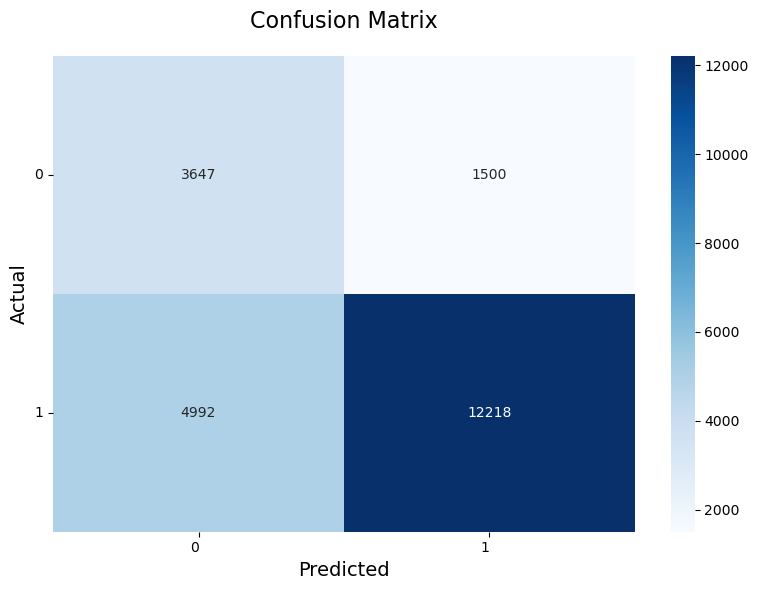

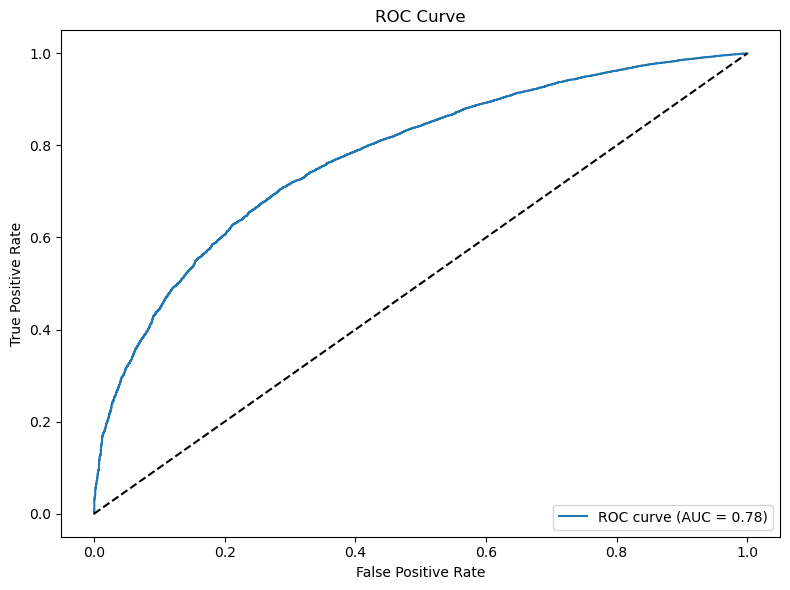

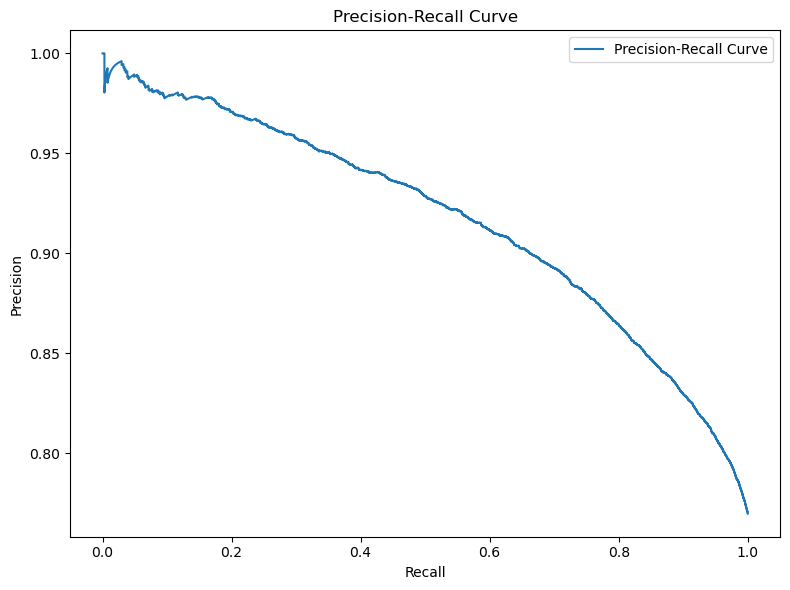

Plotting feature importances from pipeline...


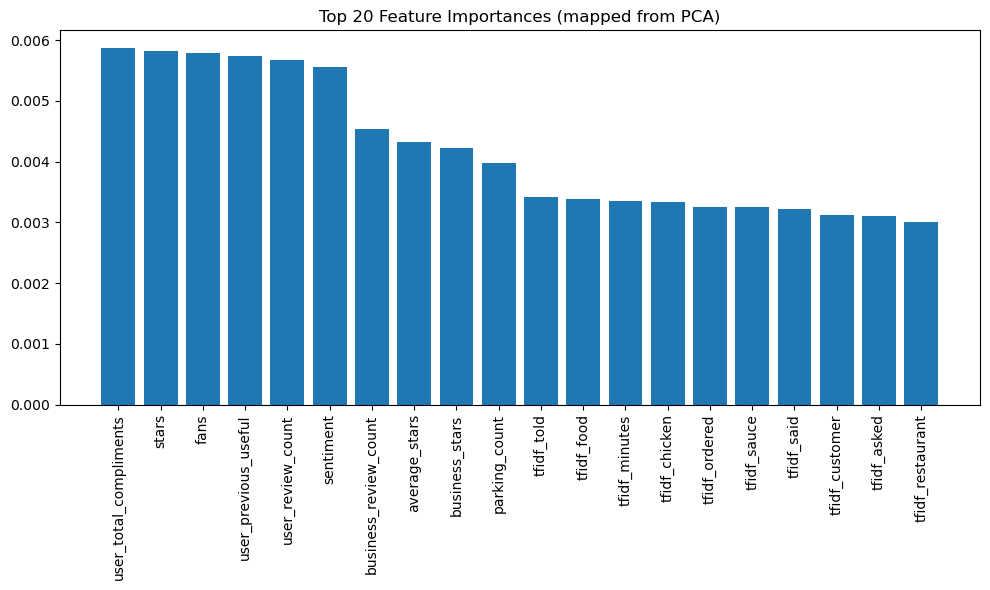

LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                 Feature  Contribution
    tfidf_bacon <= -0.15     -0.044258
  tfidf_italian <= -0.12     -0.042491
     tfidf_thai <= -0.10     -0.0

In [ ]:
comprehensive_evaluation(best_rf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

## 9. Cost-Sensitive and Ensemble Methods

Because “more useful” reviews may dominate the dataset, plain accuracy can be misleading. We use:
1. **Cost-Sensitive classification** (e.g., `class_weight='balanced'` in RandomForest).
2. **Oversampling** or **synthetic sample generation** (ADASYN, SMOTE) to handle minority classes.
3. **Ensemble** methods like AdaBoost, Stacking, or Bagging to combine the strengths of multiple base learners.
This section explores how shifting the training distribution or weighting classes can affect recall on the minority class (“less useful”).

In [ ]:
clf_cost_sensitive = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
clf_cost_sensitive.fit(X_train_ready, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=80, random_state=42)


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4263    0.8023    0.5568     20585
 more useful     0.9197    0.6771    0.7800     68839

    accuracy                         0.7060     89424
   macro avg     0.6730    0.7397    0.6684     89424
weighted avg     0.8061    0.7060    0.7286     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4119    0.7581    0.5338      5147
 more useful     0.9034    0.6762    0.7735     17210

    accuracy                         0.6951     22357
   macro avg     0.6576    0.7172    0.6536     22357
weighted avg     0.7902    0.6951    0.7183     22357



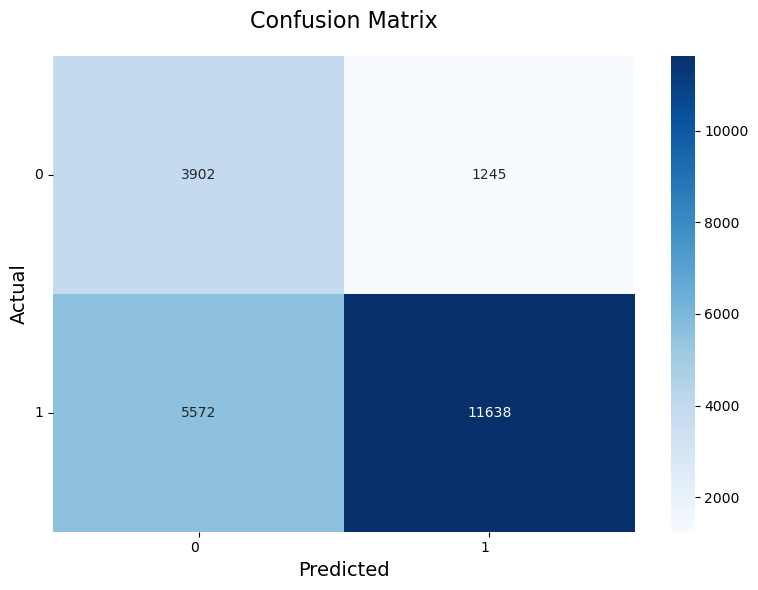

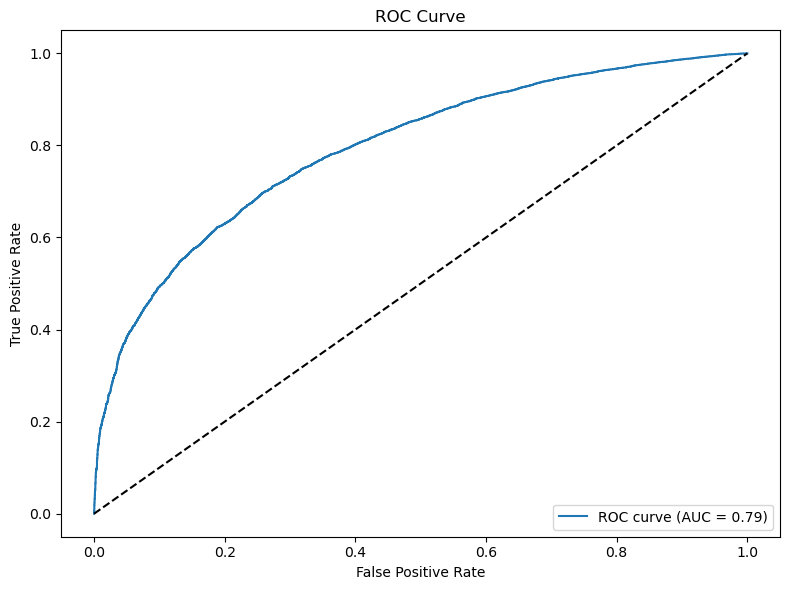

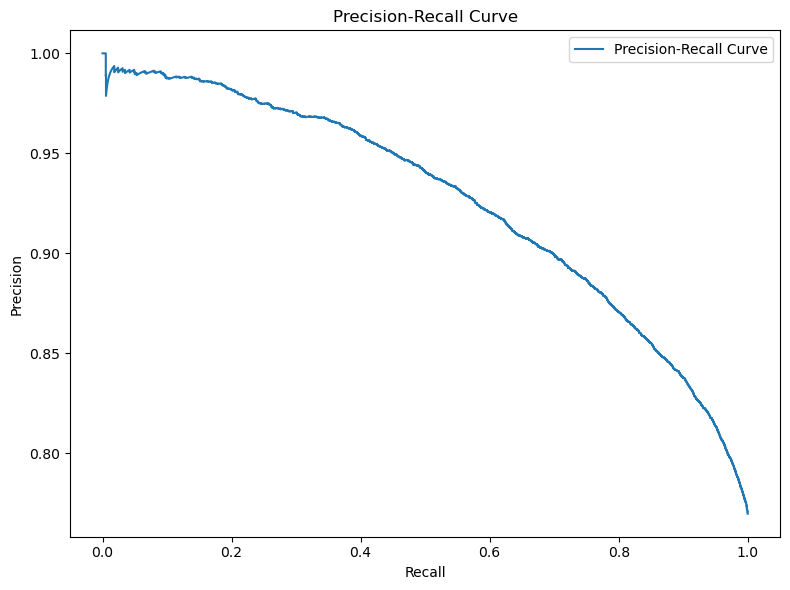

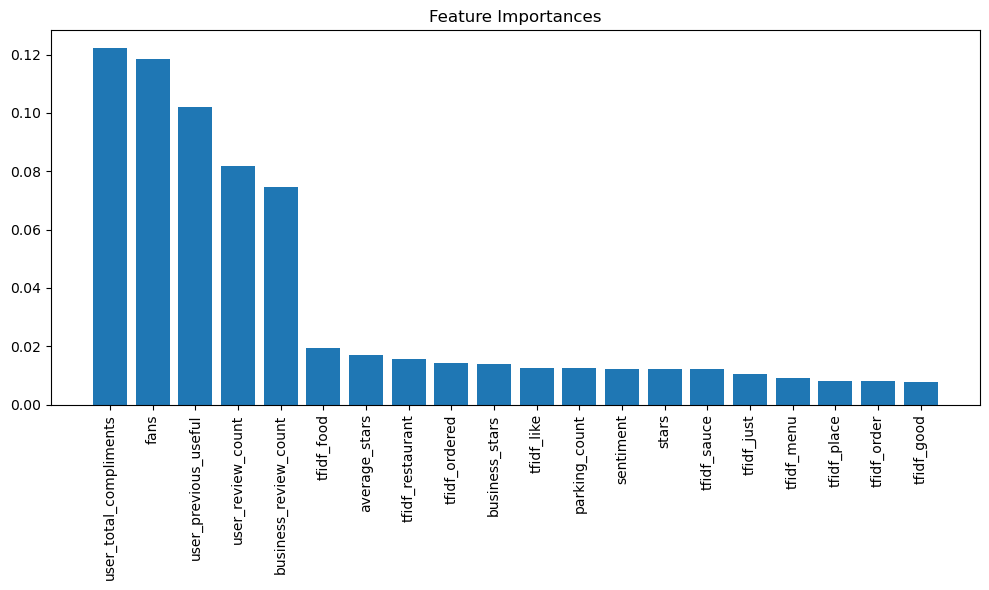

LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                                Feature  Contribution
                  -1.02 < fans <= -0.28     -0.033255
-0.90 < user_total_compliments <= -0.13   

In [ ]:
comprehensive_evaluation(clf_cost_sensitive, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_res, y_train_res = adasyn.fit_resample(X_train_ready, y_train)

clf_adasyn = RandomForestClassifier(
    n_estimators=80,
    max_depth=10,
    min_samples_split=10,
    random_state=42
)
clf_adasyn.fit(X_train_res, y_train_res)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=80,
                       random_state=42)


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.4616    0.6325    0.5337     20585
 more useful     0.8764    0.7794    0.8251     68839

    accuracy                         0.7456     89424
   macro avg     0.6690    0.7060    0.6794     89424
weighted avg     0.7809    0.7456    0.7580     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.4318    0.5891    0.4983      5147
 more useful     0.8621    0.7682    0.8124     17210

    accuracy                         0.7269     22357
   macro avg     0.6469    0.6786    0.6554     22357
weighted avg     0.7630    0.7269    0.7401     22357



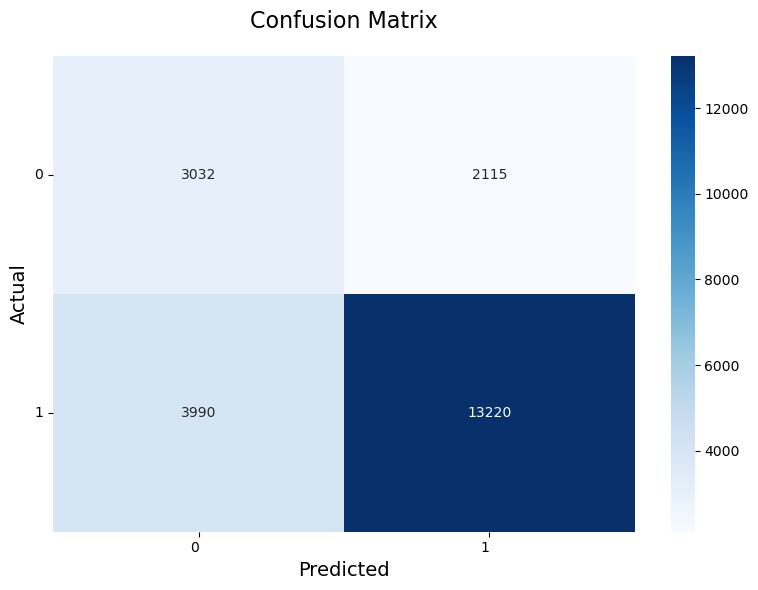

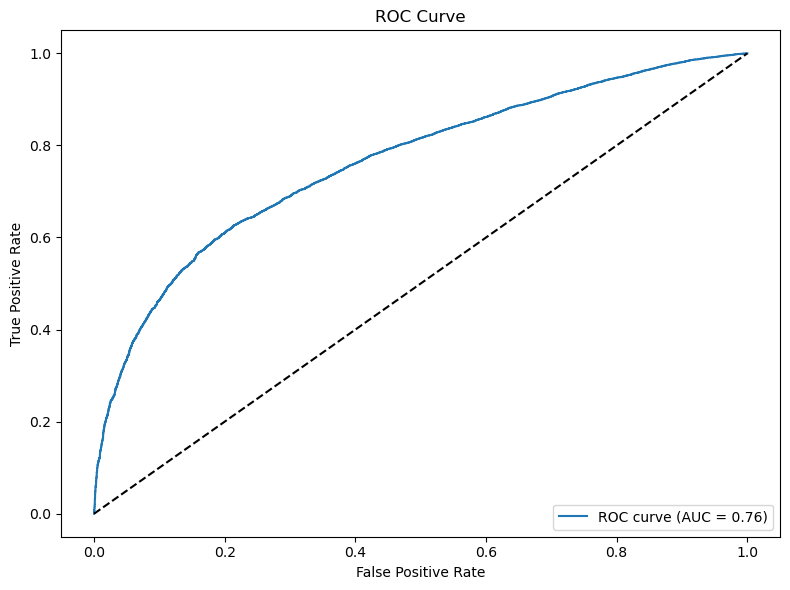

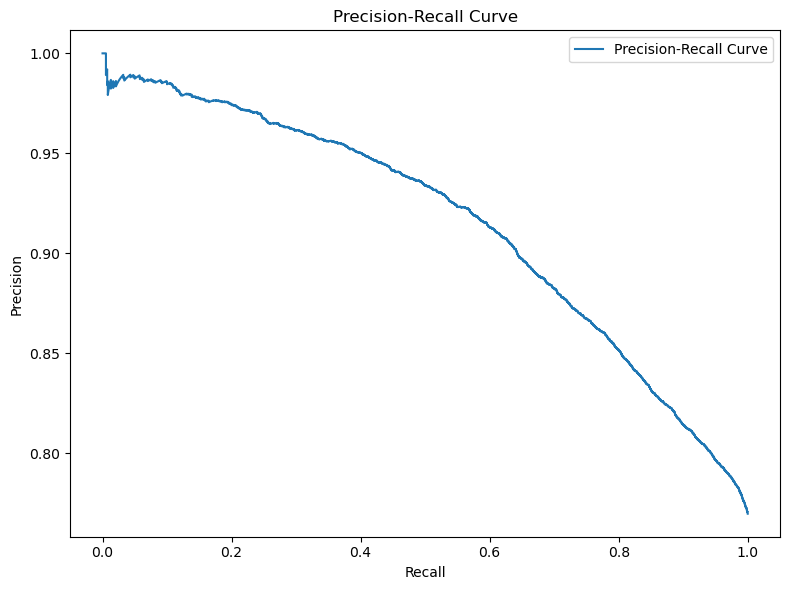

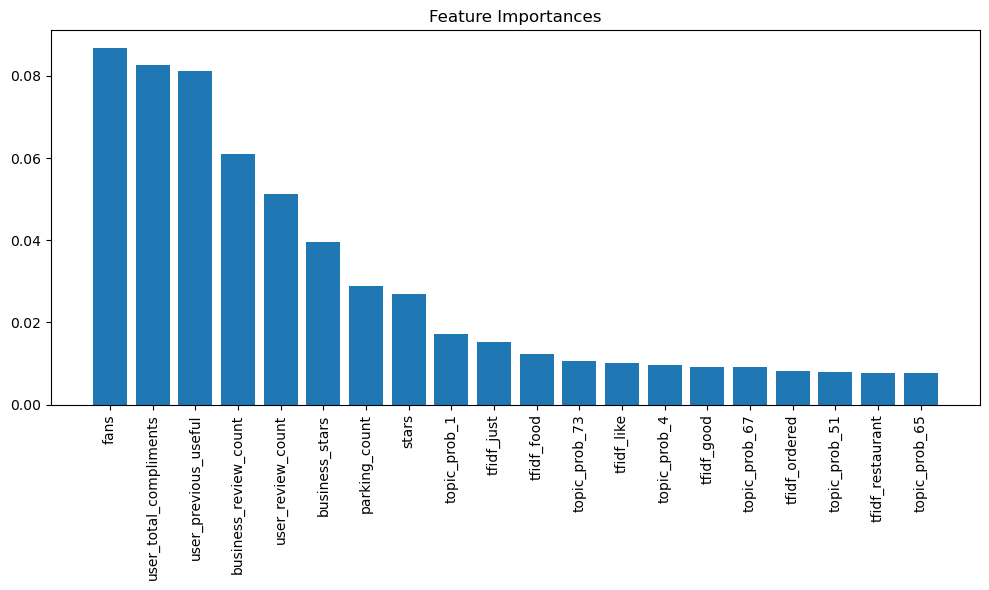

LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                                Feature  Contribution
                  -1.02 < fans <= -0.28     -0.029390
                 parking_count <= -1.20   

In [ ]:
comprehensive_evaluation(clf_adasyn, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
ada_clf.fit(X_train_ready, y_train)

AdaBoostClassifier(random_state=42)


Evaluating on training data:
              precision    recall  f1-score   support

 less useful     0.5888    0.3395    0.4306     20585
 more useful     0.8247    0.9291    0.8738     68839

    accuracy                         0.7934     89424
   macro avg     0.7067    0.6343    0.6522     89424
weighted avg     0.7704    0.7934    0.7718     89424


Evaluating on test data:
              precision    recall  f1-score   support

 less useful     0.5910    0.3338    0.4266      5147
 more useful     0.8237    0.9309    0.8740     17210

    accuracy                         0.7934     22357
   macro avg     0.7073    0.6323    0.6503     22357
weighted avg     0.7701    0.7934    0.7710     22357



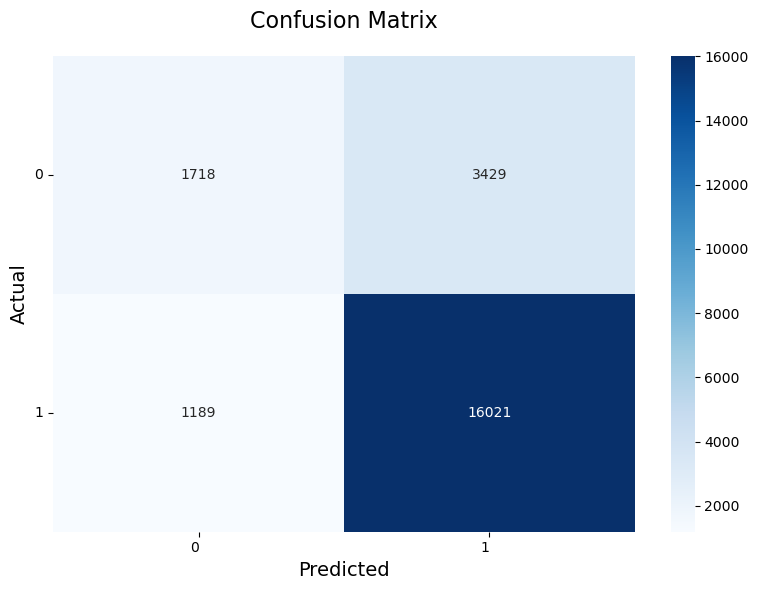

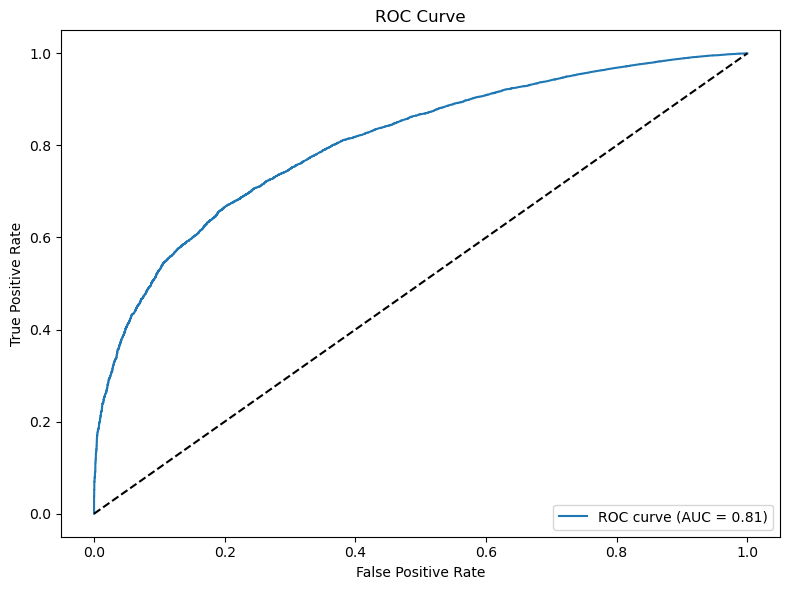

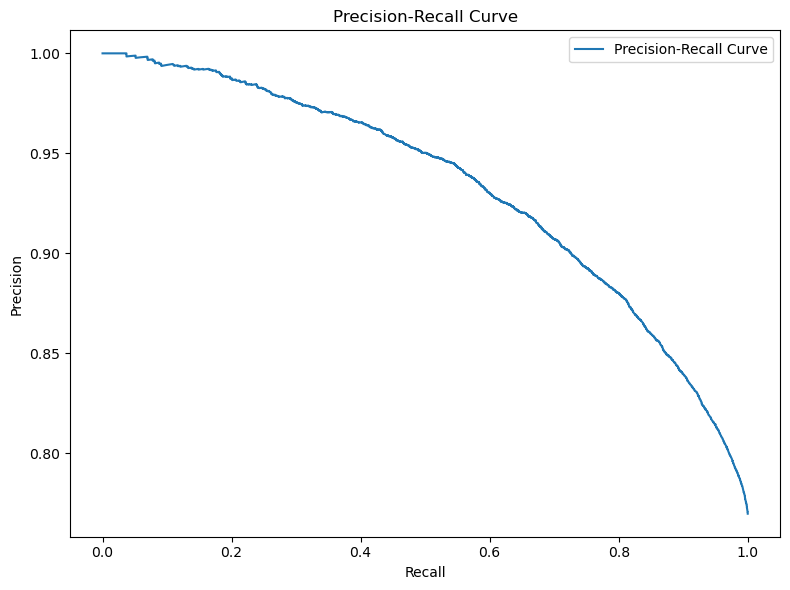

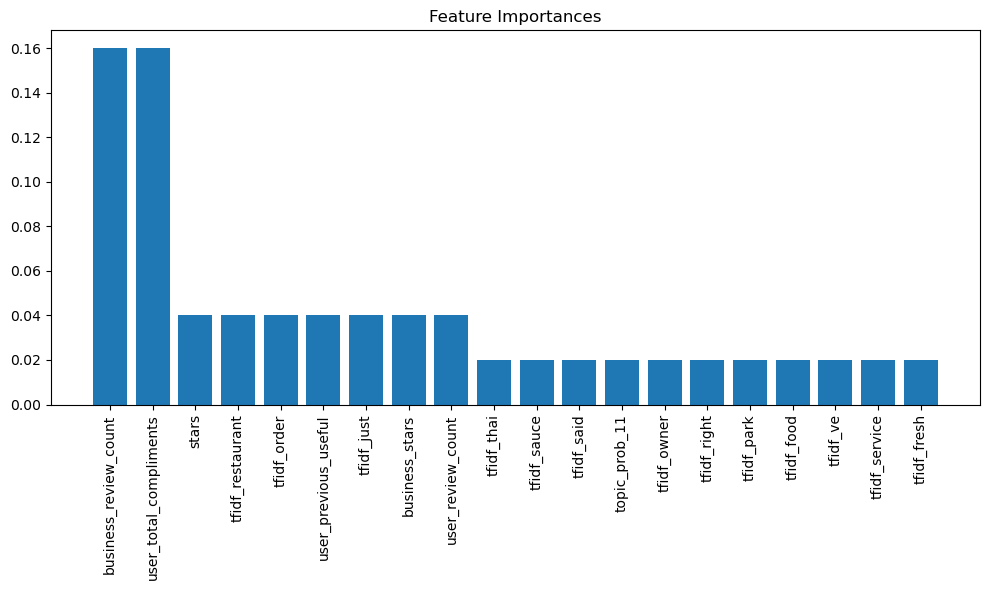

LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: less useful
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                                Feature  Contribution
                     tfidf_saw <= -0.19     -0.009207
                    tfidf_crab <= -0.13   

In [ ]:
comprehensive_evaluation(ada_clf, X_train_ready, y_train, X_test_ready, y_test,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

In [ ]:
from xgboost import XGBClassifier

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train model with best hyperparameters
best_xgb = XGBClassifier(n_estimators=100, min_child_weight=2, reg_alpha=0.1666, reg_lambda=50,
                         subsample=0.60, max_depth=5, learning_rate=0.10, gamma=0.5, colsample_bytree=0.7,
                         random_state=42, eval_metric='logloss')
best_xgb.fit(X_train_ready, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


Evaluating on training data:
              precision    recall  f1-score   support

           0     0.6520    0.3475    0.4534     20585
           1     0.8288    0.9445    0.8829     68839

    accuracy                         0.8071     89424
   macro avg     0.7404    0.6460    0.6681     89424
weighted avg     0.7881    0.8071    0.7840     89424


Evaluating on test data:
              precision    recall  f1-score   support

           0     0.6340    0.3318    0.4357      5147
           1     0.8251    0.9427    0.8800     17210

    accuracy                         0.8021     22357
   macro avg     0.7296    0.6373    0.6578     22357
weighted avg     0.7811    0.8021    0.7777     22357



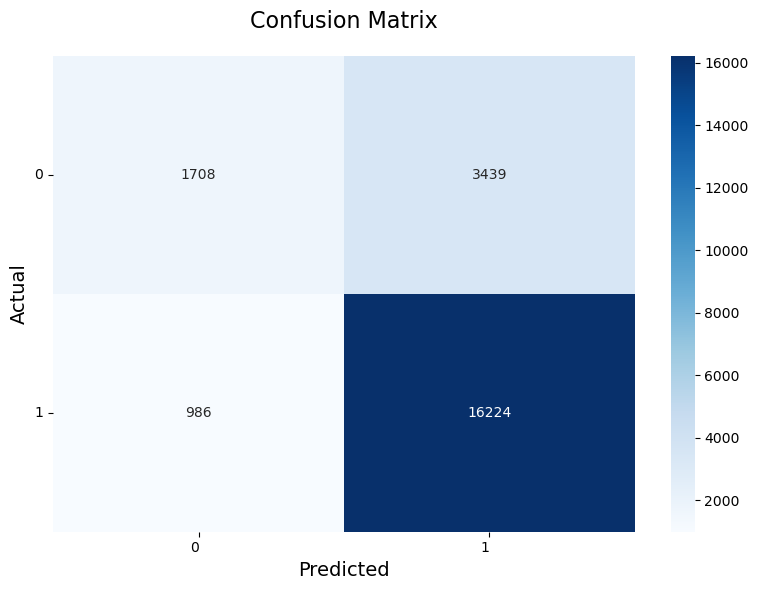

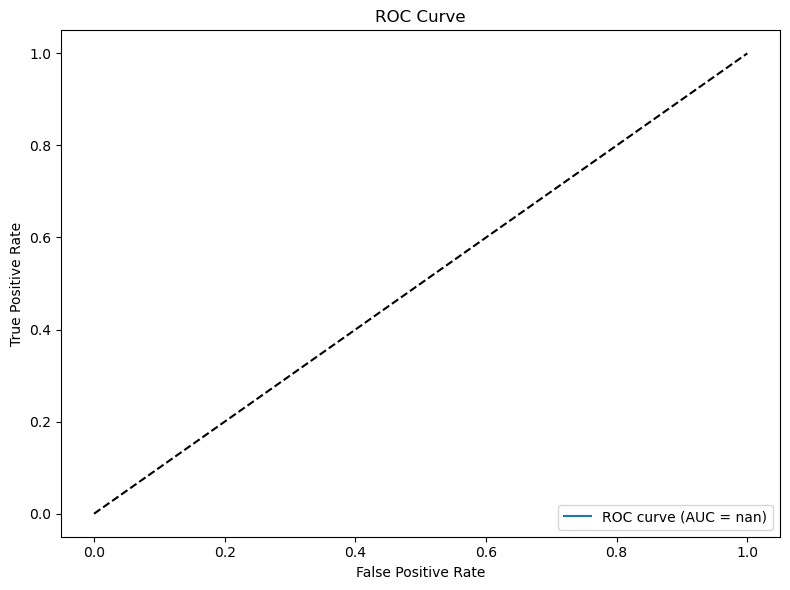

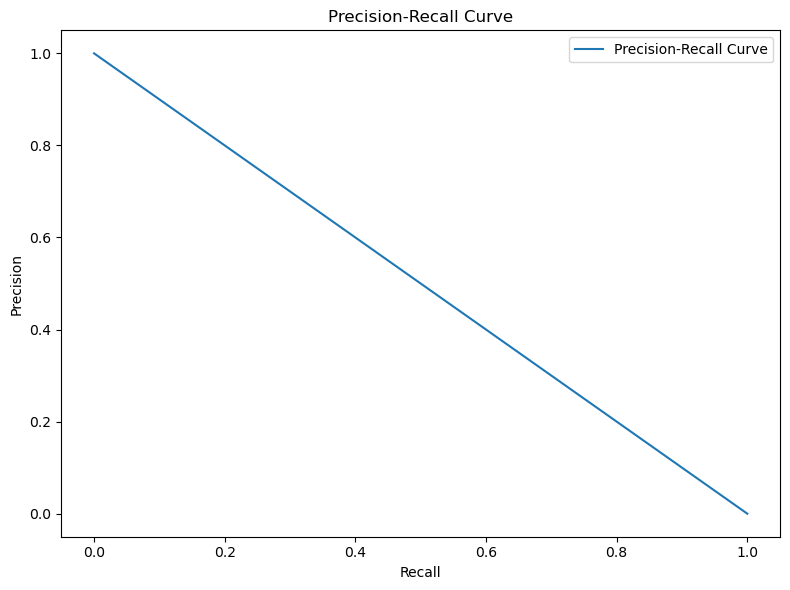

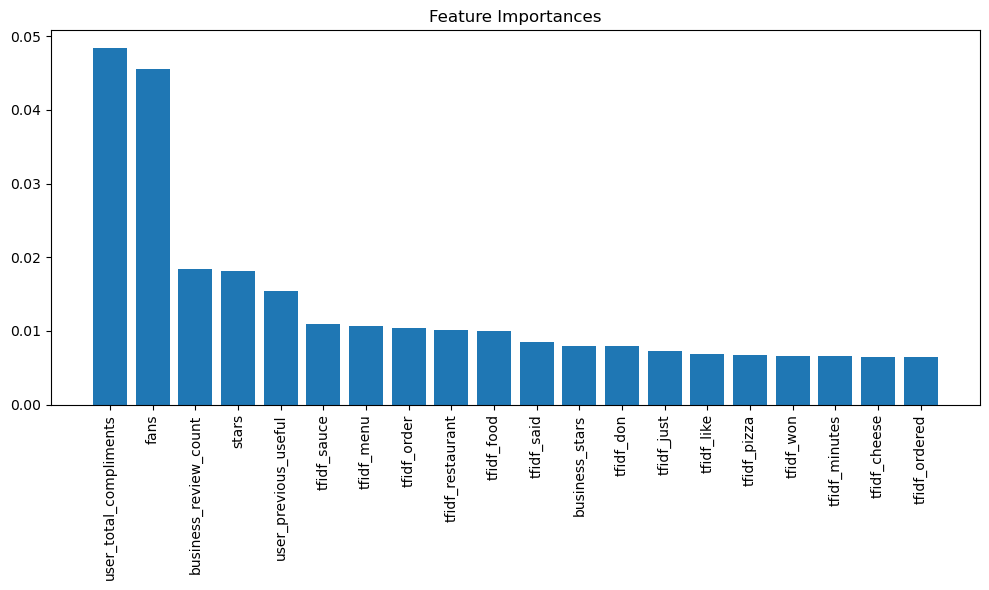

LIME Explanations for 5 Test Instances

--------------------------------------------------------------------------------
Instance 0 - Predicted Class: 0
Original Text:
We were driving through Idaho when our truck began having issues with the ignition / keys.  I called the Peterson Toyota dealership for assistance. I spoke with Greg in parts, Todd in service and Cary was my service advisor.  These folks were fantastic to work with.  Greg offered some good suggestions and Todd assisted us in getting things started.  Both of those gentleman went out of their way to help us.  Cary took care of the paperwork and handled everything else.  These guys are great!  They really went out of their way for us which means a great deal when you are stranded and from out of town.  Awesome service!!
Top 10 Features and Their Contribution Scores:
                              Feature  Contribution
              business_stars <= -0.81     -0.050287
                 0.34 < stars <= 0.98     -0.035711
    

In [ ]:
comprehensive_evaluation(best_xgb, X_train_ready, y_train_encoded, X_test_ready, y_test_encoded,
                         model_type='sklearn', feature_names=original_cols, cv=5, scoring="f1_weighted", n_jobs=-1,
                         original_X_train=X_train, original_X_test=X_test)

## 10. Deep Learning Experiments

The following sections demonstrate deep learning experiments. We tried:
- **Fine-tuned BERT** on the review text.
- **LSTM** networks for sequential text modeling.
- **Multi-Input** architectures that combine numeric and text embedding branches.

### 10.1 BERT Fine-Tuning

Prepare datasets and fine-tune a BERT model using our utility function.

In [ ]:
# Prepare train and test datasets for BERT fine-tuning
from datasets import Dataset, DatasetDict

train_df = pd.concat([X_train[['text']].reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)
test_df = pd.concat([X_test[['text']].reset_index(drop=True), y_test.reset_index(drop=True)], axis=1)
label_mapping = {"less useful": 0, "more useful": 1}
train_df['label'] = train_df['useful_category'].map(label_mapping)
test_df['label'] = test_df['useful_category'].map(label_mapping)

train_dataset = Dataset.from_pandas(train_df[['text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']])
hf_dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

def tokenize_function(examples):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")

# Fine-tune BERT using the utility function from deep_learning.py
trainer = finetune_bert(
    train_dataset=tokenized_datasets["train"],
    test_dataset=tokenized_datasets["test"],
    model_path="google-bert/bert-base-uncased",
    output_dir="./bert_finetune_results"
)

Map:   0%|          | 0/89424 [00:00<?, ? examples/s]

Map:   0%|          | 0/22357 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Evaluate the fine-tuned BERT model
predictions_output = trainer.predict(tokenized_datasets["test"])
pred_labels = np.argmax(predictions_output.predictions, axis=1)
print("BERT Fine-Tuning Classification Report:")
print(classification_report(predictions_output.label_ids, pred_labels, target_names=["less useful", "more useful"], digits=4))

BERT Fine-Tuning Classification Report:
              precision    recall  f1-score   support

 less useful     0.5748    0.1454    0.2321      5152
 more useful     0.7909    0.9678    0.8704     17205

    accuracy                         0.7783     22357
   macro avg     0.6828    0.5566    0.5513     22357
weighted avg     0.7411    0.7783    0.7233     22357



### 10.2 Keras LSTM Model

Train a Keras LSTM model for text classification using the utility function.

In [ ]:
texts = df['text'].astype(str).tolist()
labels = df['useful_category'].tolist()

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(
    texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 10000
tokenizer_keras = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer_keras.fit_on_texts(X_text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(X_text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(X_text_test)

max_length = 200
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build and train the LSTM model using the utility function from deep_learning.py
lstm_model = build_lstm_model(max_words=max_words, max_length=max_length, embedding_dim=64)
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
lstm_history = lstm_model.fit(
    X_train_pad, y_text_train,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
 47/280 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.7592 - loss: 0.6091

KeyboardInterrupt: 

In [ ]:
lstm_y_train_pred_probs = lstm_model.predict(X_train_pad)
lstm_y_train_pred = (lstm_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, lstm_y_train_pred, digits=4))

2795/2795 ━━━━━━━━━━━━━━━━━━━━ 290s 103ms/step
              precision    recall  f1-score   support

           0     0.5726    0.2059    0.3028     20606
           1     0.8005    0.9540    0.8705     68818

    accuracy                         0.7816     89424
   macro avg     0.6866    0.5799    0.5867     89424
weighted avg     0.7480    0.7816    0.7397     89424



In [ ]:
comprehensive_evaluation(lstm_model, X_train_pad, y_text_train, X_test_pad, y_text_test, model_type='keras', original_X_test=X_test)


Evaluating deep learning model on test set...
Test evaluation results: [0.4774148464202881, 0.7776535153388977]
699/699 ━━━━━━━━━━━━━━━━━━━━ 72s 103ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.5502    0.1924    0.2851      5152
           1     0.7976    0.9529    0.8684     17205

    accuracy                         0.7777     22357
   macro avg     0.6739    0.5726    0.5767     22357
weighted avg     0.7406    0.7777    0.7339     22357



### 10.3 Multi-Input Model (Text + Other Features)

This model combines text features (processed via an embedding and LSTM) with additional numeric features.

In [ ]:
# Prepare text data (reuse tokenizer)
text_train = X_train['text'].astype(str).tolist()
text_test = X_test['text'].astype(str).tolist()

tokenizer_keras.fit_on_texts(text_train)
X_train_seq = tokenizer_keras.texts_to_sequences(text_train)
X_test_seq = tokenizer_keras.texts_to_sequences(text_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# Prepare additional features: drop the text column and one-hot encode categoricals
X_train_other = X_train.drop(columns=['text']).copy()
X_test_other = X_test.drop(columns=['text']).copy()
X_train_other = pd.get_dummies(X_train_other, drop_first=True)
X_test_other = pd.get_dummies(X_test_other, drop_first=True)
X_train_other, X_test_other = X_train_other.align(X_test_other, join='inner', axis=1)

In [ ]:
scaler = StandardScaler()
X_train_other_scaled = scaler.fit_transform(X_train_other)
X_test_other_scaled = scaler.transform(X_test_other)

In [ ]:
# Encode target variable
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [ ]:
# Build and train the multi-input model using the utility function
num_other_features = X_train_other_scaled.shape[1]
multi_input_model = build_multi_input_model(max_length=max_length, max_words=max_words, num_other_features=num_other_features, embedding_dim=64)
multi_input_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     33,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_input         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │        416 │ other_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 677,633 (2.58 MB)

 Trainable params: 677,633 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history = multi_input_model.fit(
    {'text_input': X_train_pad, 'other_input': X_train_other_scaled},
    y_train_enc,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 64s 224ms/step - accuracy: 0.7716 - loss: 0.4848 - val_accuracy: 0.7907 - val_loss: 0.4341
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 64s 229ms/step - accuracy: 0.7876 - loss: 0.4390 - val_accuracy: 0.7892 - val_loss: 0.4310
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 64s 228ms/step - accuracy: 0.7928 - loss: 0.4316 - val_accuracy: 0.7890 - val_loss: 0.4335
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 66s 235ms/step - accuracy: 0.7954 - loss: 0.4170 - val_accuracy: 0.7841 - val_loss: 0.4437
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
mi_y_train_pred_probs = multi_input_model.predict({'text_input': X_train_pad, 'other_input': X_train_other_scaled})
mi_y_train_pred = (mi_y_train_pred_probs > 0.5).astype(int).flatten()
y_true = y_text_train.flatten()
print(classification_report(y_true, mi_y_train_pred, digits=4))

2795/2795 ━━━━━━━━━━━━━━━━━━━━ 29s 10ms/step
              precision    recall  f1-score   support

           0     0.5973    0.2921    0.3923     20585
           1     0.8164    0.9411    0.8743     68839

    accuracy                         0.7917     89424
   macro avg     0.7068    0.6166    0.6333     89424
weighted avg     0.7659    0.7917    0.7634     89424




Evaluating deep learning model on test set...
Test evaluation results: [0.42769819498062134, 0.7946057319641113]
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.6101    0.2988    0.4011      5147
           1     0.8181    0.9429    0.8760     17210

    accuracy                         0.7946     22357
   macro avg     0.7141    0.6208    0.6386     22357
weighted avg     0.7702    0.7946    0.7667     22357



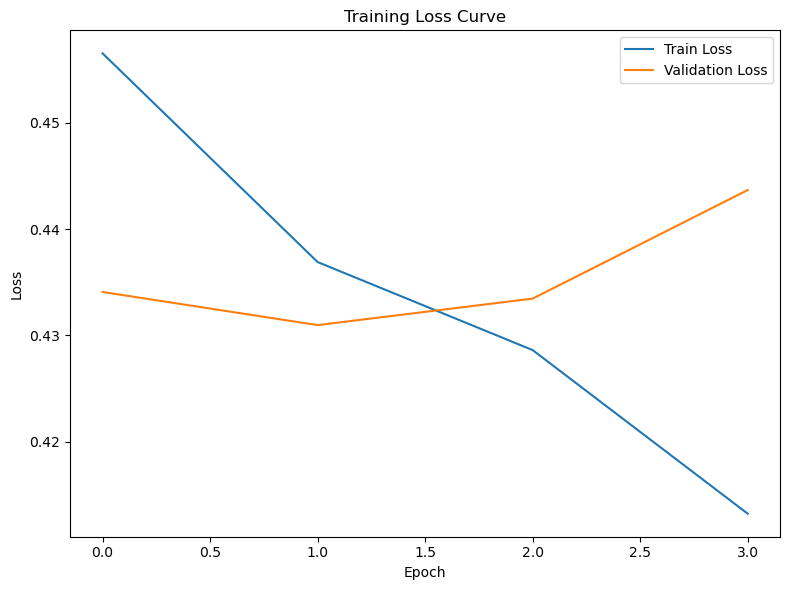

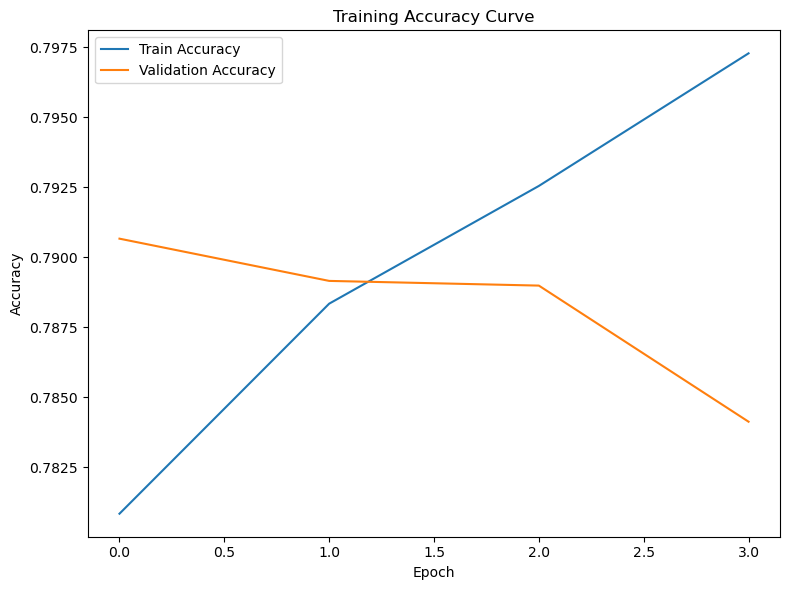

In [ ]:
comprehensive_evaluation(multi_input_model, {'text_input': X_train_pad, 'other_input': X_train_other_scaled}, y_text_train, {'text_input': X_test_pad, 'other_input': X_test_other_scaled}, y_text_test, model_type='keras', original_X_test=X_test, history=history)